In [1]:
from covariates_gclass import *
import seaborn as sns
import networkx as nx
import pandas as pd
from graspy.embed.ase import AdjacencySpectralEmbed as ASE
from graspy.utils import get_lcc
from graspy.plot import pairplot
sns.set()

In [2]:
def build_graph(dataframe):
    source = np.array(dataframe[dataframe.columns[0]])
    target = np.array(dataframe[dataframe.columns[1]])
    
    nodes = np.unique(np.concatenate((source, target))) # grab all unique nodes
    A = np.zeros((len(nodes), len(nodes))) # initialize empty adjacency matrix
    
    for i, node in enumerate(nodes): # for all unique nodes
        idx = np.where(source == node)[0] # find indices for all adjacent nodes
        temp_targets = target[idx] # find node ids for all adjacent nodes
        for target_node in temp_targets:
            adj_idx = np.where(nodes == target_node)
            A[i, adj_idx] += 1
            A[adj_idx, i] += 1 # symmetric 
    
    return nodes, A

def sort_labels(dataframe):
    nodes, inv = np.unique(dataframe.iloc[:, 0].values, return_inverse=True)
    labels = np.array(dataframe.iloc[:, -1].values)
    
    sorted_labels=[labels[np.where(nodes == dataframe.iloc[i, 0])[0][0]] for i in range(len(nodes))]
    
    return np.array(sorted_labels)

In [3]:
df = pd.read_csv('cora/cora.cites', delimiter='\t', header=None)
df.columns = ['cited', 'citer']
df.head()

,cited,citer
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [4]:
attributes_df = pd.read_csv('cora/cora.content', delimiter='\t', header=None, low_memory=False)
sorted_labels = sort_labels(attributes_df)
attributes_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [5]:
nodes, A = build_graph(df)
A = (A + A.T)/2 
lcc, lcc_idx = get_lcc(A, return_inds=True)
lcc_nodes = nodes[lcc_idx]
lcc_labels = sorted_labels[lcc_idx]
attributes = np.array(attributes_df.iloc[lcc_idx, 1:-1])
new_idx = np.arange(len(lcc_idx))
lcc_idx, len(lcc_idx), np.sum(lcc)

(array([   0,    1,    2, ..., 2703, 2704, 2707]), 2485, 10418.0)

In [6]:
ase = ASE()
lcc = lcc + 1*np.diag(np.sum(lcc, axis=0))/len(lcc_idx)

In [7]:
X = ase.fit_transform(lcc)
X.shape

(2485, 6)

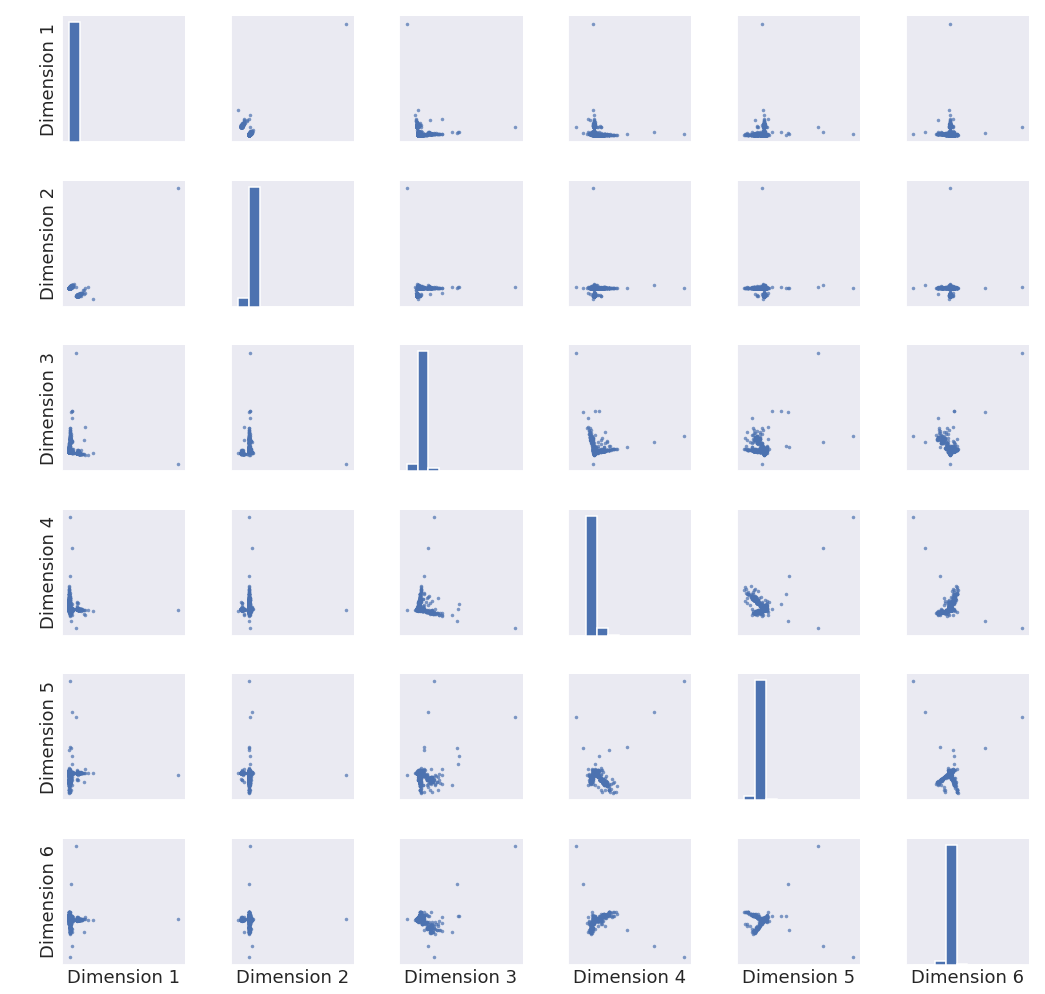

In [8]:
pairplot(X)

In [9]:
# all_labels = attributes_df.iloc[:, -1].values
# new_labels = np.array([all_labels[np.where(attributes_df.iloc[:, 0].values == i)[0][0]] for i in nodes])
unique_labels, re_idx, counts = np.unique(lcc_labels, return_inverse=True, return_counts=True)
class_idx = [np.where(re_idx == i)[0] for i in np.unique(re_idx)]

In [10]:
np.random.seed(1)
class_train_idx = [np.random.choice(class_idx[i], int(0.1*counts[i]), replace=False) for i in range(len(class_idx))]
train_idx = np.concatenate(class_train_idx)
test_idx = np.array([i for i in range(len(lcc)) if i not in train_idx])

In [11]:
#- Total number of seeds
true_labels = lcc_labels
m = len(train_idx)

#- estimate class probabilities
pi_hats = np.array([len(i)/len(train_idx) for i in class_train_idx])

ase_obj = ASE(n_components=3, n_elbows=2)
X = ase_obj.fit_transform(lcc)

Z = attributes

XZ = np.concatenate((X, Z), axis=1)

#- Store mvn samples corresponding to seeds
seeds_norm = X[train_idx]

cov = np.cov(X[train_idx], rowvar=False)

#- Estimate normal parameters using seeds
params = []
for i in class_train_idx:
    temp_params = estimate_normal_parameters(X[i])
    params.append(temp_params)

#- Store uniform samples corresponding to seeds
seeds_beta = Z[train_idx]

In [27]:
#- Using conditional indendence assumption (RF, KNN used for posterior estimates)
# if errors is None:
from tqdm import tqdm
import time

errors = [[] for _ in range(5)]

for _ in tqdm(range(2)):
    start = time.time()

    temp_pred = QDA(X[test_idx], pi_hats, params)
    qda_preds = temp_pred
    temp_error = np.sum(unique_labels[temp_pred.astype(int)] == true_labels[test_idx])/len(test_idx)
    errors[0].append(temp_error)

    rf1 = RF(n_estimators=1000, max_depth=int(np.round(np.log(seeds_beta.shape[0]))))
    rf1.fit(seeds_beta, true_labels[train_idx])

    knn1 = KNN(n_neighbors=int(np.round(np.log(seeds_beta.shape[0]))))
    knn1.fit(seeds_beta, true_labels[train_idx])

    smooth = True

    if smooth:
        temp_pred = classify(X[test_idx], Z[test_idx], params, rf1, m = m)
        temp_error = np.sum(unique_labels[temp_pred.astype(int)] == true_labels[test_idx])/len(test_idx)
        errors[1].append(temp_error)
        
        print(unique_labels[temp_pred.astype(int)], true_labels[test_idx])

        temp_pred = classify(X[test_idx], Z[test_idx], params, knn1, m = m)
        temp_error = np.sum(unique_labels[temp_pred.astype(int)] == true_labels[test_idx])/len(test_idx)
        errors[2].append(temp_error)
    else:
        temp_pred = classify(X[test_idx], Z[test_idx], params, rf1)
        temp_error = np.sum(unique_labels[temp_pred.astype(int)] == true_labels[test_idx])/len(test_idx)
        errors[1].append(temp_error)

        temp_pred = classify(X[test_idx], Z[test_idx], params, knn1)
        temp_error = np.sum(unique_labels[temp_pred.astype(int)] == true_labels[test_idx])/len(test_idx)
        errors[2].append(temp_error)

    #- Not using conditional independence assumption (RF, KNN used for classification)
    XZseeds = np.concatenate((seeds_norm, seeds_beta), axis=1)

    rf2 = RF(n_estimators=1000, max_depth=int(np.round(np.log(m))))
    rf2.fit(XZseeds, true_labels[train_idx])
    temp_pred = rf2.predict(XZ[test_idx])
    temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
    errors[3].append(temp_error)

    knn2 = KNN(n_neighbors=int(np.round(np.log(m))))
    knn2.fit(XZseeds, true_labels[train_idx])

    temp_pred = knn2.predict(XZ[test_idx])
    temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
    errors[4].append(temp_error)


  0%|          | 0/2 [00:00<?, ?it/s]

['Case_Based' 'Reinforcement_Learning' 'Genetic_Algorithms' ...
 'Case_Based' 'Theory' 'Case_Based'] ['Neural_Networks' 'Genetic_Algorithms' 'Probabilistic_Methods' ...
 'Probabilistic_Methods' 'Case_Based' 'Case_Based']


KeyboardInterrupt: 

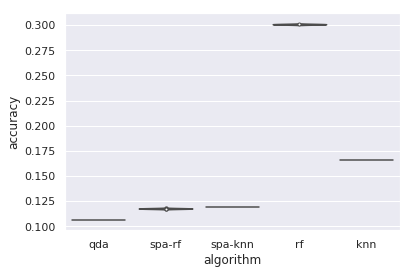

In [25]:
np.concatenate(errors)
algorithms = ['qda', 'spa-rf', 'spa-knn', 'rf', 'knn']
algos = np.concatenate([2*[algo] for algo in algorithms])

# Usual boxplot
import pandas as pd
data = np.concatenate(errors)
df = pd.DataFrame(np.concatenate((np.array(data).reshape(-1, 1), np.array(algos).reshape(-1, 1)), axis=1))
df1 = pd.DataFrame(np.concatenate((np.array(data[2:]).reshape(-1, 1), np.array(algos[2:]).reshape(-1, 1)), axis=1))
df.columns = ['accuracy', 'algorithm']
df1.columns = ['accuracy', 'algorithm']
df['accuracy'] = pd.to_numeric(df['accuracy'])
df1['accuracy'] = pd.to_numeric(df1['accuracy'])

ax = sns.violinplot(x='algorithm', y='accuracy', data=df)
# ax.axhline(y = 0.9875, label = 'EXLine', c = 'r', alpha=0.5)
# ax.axhline(y=0.85125, label = 'current best ta1 pipeline', c = 'k', alpha=0.5)
plt.savefig('all_algos_cora_overleaf.png')

In [ ]:
ax = sns.violinplot(x='algorithm', y='accuracy', data=df1)
# ax.axhline(y = 0.9875, label = 'EXLine', c = 'r', alpha=0.5)
# ax.axhline(y=0.85125, label = 'current best ta1 pipeline', c = 'k', alpha=0.5)
plt.savefig('no_QDA_cora_overleaf.png')